In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Data Processing Libraries
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus
from string import punctuation
from bs4 import BeautifulSoup

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, precision_score, recall_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Text Cleaning Function
def clean_text(text):
    token = ToktokTokenizer()
    lemma = WordNetLemmatizer()
    stop_words = set(corpus.stopwords.words("english"))
    punct = punctuation

    text = str(text).lower().strip()
    text = BeautifulSoup(text, "html.parser").get_text()
    words = token.tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stop_words and w not in punct]
    return ' '.join(words)

# Prepare Data for Deep Learning
def prepare_data_for_dl(question_df, max_words=5000, max_len=200):
    # Prepare text
    texts = question_df['Text'].values

    # Tokenize text
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, truncating='post', padding='post')

    # Prepare labels
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(question_df['Tags'])

    return padded_sequences, y, tokenizer, mlb

# Build LSTM Model
def build_lstm_model(max_words, max_len, num_classes, embedding_dim=100):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build GRU Model
def build_gru_model(max_words, max_len, num_classes, embedding_dim=100):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_len),
        GRU(128, return_sequences=True),
        Dropout(0.5),
        GRU(64),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Download dataset
path = kagglehub.dataset_download("stackoverflow/stacksample")
print("Path to dataset files:", path)

# Construct file paths
questions_path = os.path.join(path, 'Questions.csv')
tags_path = os.path.join(path, 'Tags.csv')

# Data Loading
question_df = pd.read_csv(questions_path, encoding="ISO-8859-1")
tag_df = pd.read_csv(tags_path, encoding="ISO-8859-1", dtype={'Tag': str})

tag_df['Tag'] = tag_df['Tag'].astype(str)
grouped_tags = tag_df.groupby("Id")['Tag'].apply(lambda tag_df: ' '.join(tag_df))
grouped_tags_final = pd.DataFrame({'Id': grouped_tags.index, 'Tags': grouped_tags.values})

question_df.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)
question_df = question_df.merge(grouped_tags_final, on='Id')

# Filter high-score questions
question_df = question_df[question_df['Score'] > 5]
question_df.drop(columns=['Id', 'Score'], inplace=True)

# Clean and Prepare Tags
question_df['Tags'] = question_df['Tags'].apply(lambda x: str(x).split(', '))
flat_list = [item for sublist in question_df['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
tags_features = [word[0] for word in keywords.most_common(10)]

def most_common(tags):
    return [tag for tag in tags if tag in tags_features]

question_df['Tags'] = question_df['Tags'].apply(lambda x: most_common(x))
question_df['Tags'] = question_df['Tags'].apply(lambda x: x if len(x) > 0 else None)
question_df.dropna(subset=['Tags'], inplace=True)

# Parameters
MAX_WORDS = 5000
MAX_LEN = 200

100%|██████████| 1.11G/1.11G [00:19<00:00, 60.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/stackoverflow/stacksample/versions/2


In [ ]:
print(question_df.head())

                                                 Title  \
205          Code to ask yes/no question in javascript   
223       Table cells larger than they are meant to be   
377  What is the best quick-read Python book out th...   
379                      duplicating jQuery datepicker   
471                        Writing/Using C++ Libraries   

                                                  Body                 Tags  
205  <p>I could only find the function <code>confir...         [javascript]  
223  <p>I've created a map system for a game that r...           [html css]  
377  <p>I am taking a class that requires Python. W...             [python]  
379  <p>The <code>datepicker</code> function only w...  [javascript jquery]  
471  <p>I am looking for basic examples/tutorials o...                [c++]  


In [ ]:
# Text Cleaning
nltk.download('stopwords')
nltk.download('wordnet')

token = ToktokTokenizer()
punct = punctuation
lemma = WordNetLemmatizer()
stop_words = set(corpus.stopwords.words("english"))

def clean_text(text):
    text = text.lower().strip()
    text = BeautifulSoup(text, "html.parser").get_text()
    words = token.tokenize(text)
    words = [lemma.lemmatize(w) for w in words if w not in stop_words and w not in punct]
    return ' '.join(words)

question_df['Body'] = question_df['Body'].apply(clean_text)
question_df['Title'] = question_df['Title'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-4-1ebba17c1382>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Vectorization
X1 = question_df['Body']
X2 = question_df['Title']
y = question_df['Tags']

multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

vectorizer_X1 = TfidfVectorizer(max_features=1000)
vectorizer_X2 = TfidfVectorizer(max_features=1000)

X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
X_tfidf = hstack([X1_tfidf, X2_tfidf])

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size=0.2, random_state=0)

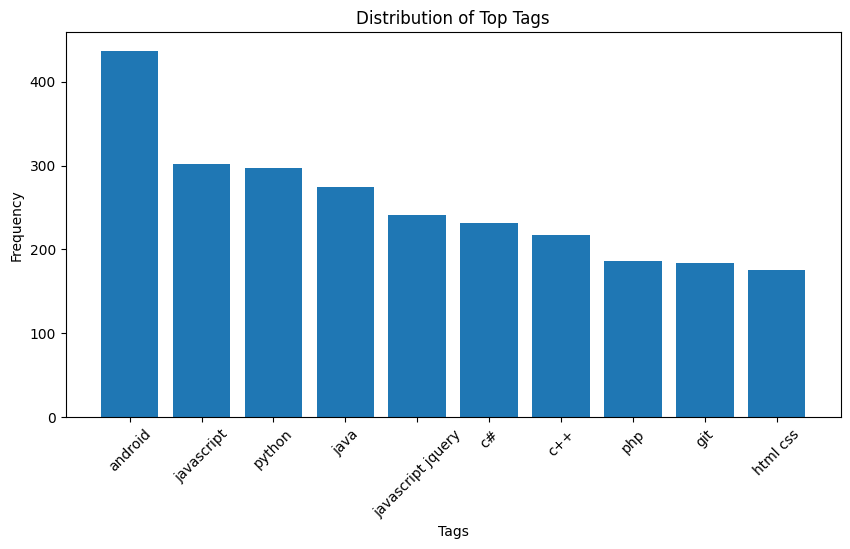

In [ ]:
# Calculate tag counts directly for the filtered top tags
tag_counts = dict(zip(multilabel_binarizer.classes_, y_bin.sum(axis=0)))

# Only include the top tags from tags_features
top_tag_counts = {tag: tag_counts.get(tag, 0) for tag in tags_features}

# Plot Distribution of Top Tags
plt.figure(figsize=(10, 5))
plt.bar(top_tag_counts.keys(), top_tag_counts.values())
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Top Tags')
plt.xticks(rotation=45)
plt.show()

# Test new code

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.1022 - loss: 0.4986 - val_accuracy: 0.1838 - val_loss: 0.3202
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.1422 - loss: 0.3275 - val_accuracy: 0.1838 - val_loss: 0.3175
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.1922 - loss: 0.3190 - val_accuracy: 0.2500 - val_loss: 0.2997
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.2937 - loss: 0.2887 - val_accuracy: 0.3015 - val_loss: 0.2814
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.3885 - loss: 0.2599 - val_accuracy: 0.4240 - val_loss: 0.2441
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5307 - loss: 0.2138 - val_accuracy: 0.4265 - val_loss: 0.2338
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.6504 - loss: 0.1794 - val_accuracy: 0.5098 - val_loss: 0.2132
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.7807 - loss: 0.1361 - val_accuracy: 0.5343 - val_loss: 0.2194

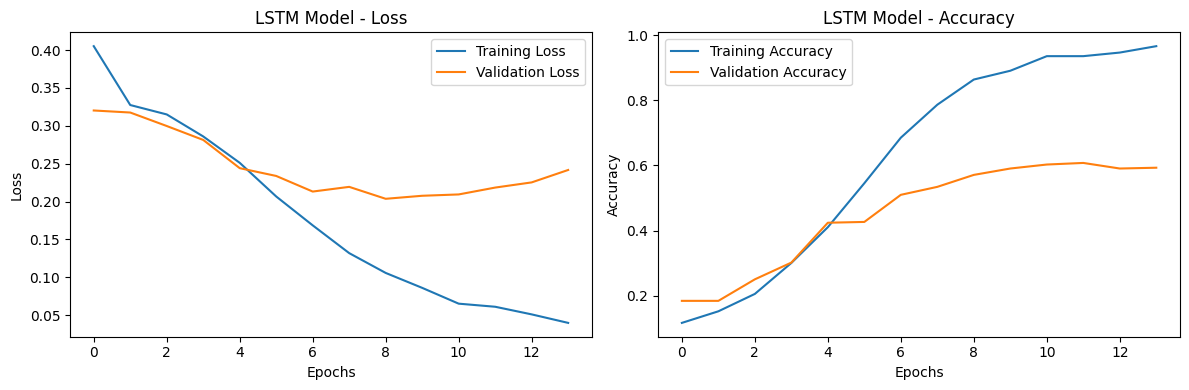

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


26/26 ━━━━━━━━━━━━━━━━━━━━ 108s 4s/step - accuracy: 0.1177 - loss: 0.5312 - val_accuracy: 0.1838 - val_loss: 0.3223
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.1362 - loss: 0.3354 - val_accuracy: 0.1936 - val_loss: 0.3162
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.2148 - loss: 0.3206 - val_accuracy: 0.2721 - val_loss: 0.2869
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.3539 - loss: 0.2756 - val_accuracy: 0.4485 - val_loss: 0.2425
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.5903 - loss: 0.2059 - val_accuracy: 0.5662 - val_loss: 0.2100
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7538 - loss: 0.1463 - val_accuracy: 0.6078 - val_loss: 0.1926
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8473 - loss: 0.1079 - val_accuracy: 0.6299 - val_loss: 0.1817
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9238 - loss: 0.0715 - val_accuracy: 0.6446 - val_loss: 0.18

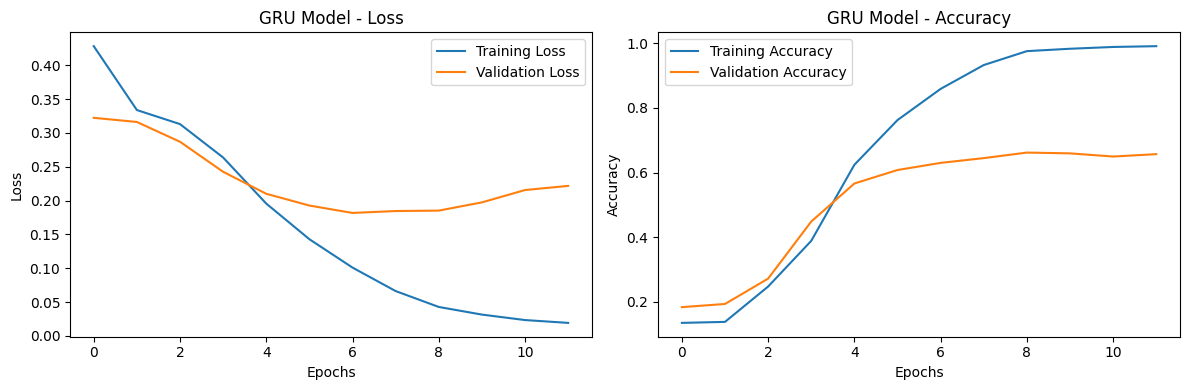

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# Data Processing Libraries
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import corpus
from string import punctuation
from bs4 import BeautifulSoup

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Existing data processing code...
# (Keep all the previous data processing code from the original script)

# Text Preprocessing for RNN
max_words = 10000  # Maximum number of words to keep
max_len = 200      # Maximum length of each sequence

# Create Keras Tokenizer
keras_tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
keras_tokenizer.fit_on_texts(question_df['Body'] + ' ' + question_df['Title'])

# Convert text to sequences
X1_seq = keras_tokenizer.texts_to_sequences(question_df['Body'])
X2_seq = keras_tokenizer.texts_to_sequences(question_df['Title'])

# Pad sequences
X1_pad = pad_sequences(X1_seq, maxlen=max_len, padding='post', truncating='post')
X2_pad = pad_sequences(X2_seq, maxlen=max_len, padding='post', truncating='post')

# Combine padded sequences
X_pad = np.concatenate([X1_pad, X2_pad], axis=1)

# Split data
X_train_pad, X_test_pad, y_train, y_test = train_test_split(
    X_pad, y_bin, test_size=0.2, random_state=42
)

# Function to create and train RNN models
def create_rnn_model(model_type='lstm', num_classes=len(tags_features)):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=max_words, output_dim=128,
                        input_length=X_train_pad.shape[1]))
    model.add(Dropout(0.3))

    # RNN Layer
    if model_type == 'lstm':
        model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    elif model_type == 'gru':
        model.add(Bidirectional(GRU(units=128, return_sequences=True)))

    model.add(Dropout(0.3))

    # Additional RNN Layer
    if model_type == 'lstm':
        model.add(Bidirectional(LSTM(units=64)))
    elif model_type == 'gru':
        model.add(Bidirectional(GRU(units=64)))

    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(num_classes, activation='sigmoid'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Training and Evaluation Function
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train Model
    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping]
    )

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Evaluation Metrics
    hamming = hamming_loss(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary, average='macro')
    recall = recall_score(y_test, y_pred_binary, average='macro')
    f1 = f1_score(y_test, y_pred_binary, average='macro')

    print(f"{model_name} Model Metrics:")
    print(f"Hamming Loss: {hamming}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return history

# Train LSTM Model
lstm_model = create_rnn_model(model_type='lstm')
lstm_history = train_and_evaluate_model(
    lstm_model, X_train_pad, X_test_pad, y_train, y_test, "LSTM"
)

# Train GRU Model
gru_model = create_rnn_model(model_type='gru')
gru_history = train_and_evaluate_model(
    gru_model, X_train_pad, X_test_pad, y_train, y_test, "GRU"
)

# Optionally, save models
lstm_model.save('stackoverflow_lstm_model.h5')
gru_model.save('stackoverflow_gru_model.h5')

In [ ]:
def display_predictions(model, X_test, y_test, multilabel_binarizer):
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Decode predictions and true labels
    true_tags = multilabel_binarizer.inverse_transform(y_test)
    pred_tags = multilabel_binarizer.inverse_transform(y_pred_binary)

    # Convert test sequences back to text for context
    word_index = keras_tokenizer.word_index
    reverse_word_index = {v: k for k, v in word_index.items()}

    def sequence_to_text(sequence):
        # Take first half (body) and second half (title)
        mid = len(sequence) // 2
        body_seq = sequence[:mid]
        title_seq = sequence[mid:]

        # Convert sequences back to text
        body_words = [reverse_word_index.get(i, '?') for i in body_seq if i != 0]
        title_words = [reverse_word_index.get(i, '?') for i in title_seq if i != 0]

        return {
            'body': ' '.join(body_words),
            'title': ' '.join(title_words)
        }

    # Display results
    print("\nSample Predictions:")
    print("-" * 50)

    # Display first 5 predictions
    for i in range(5):
        text = sequence_to_text(X_test[i])
        print(f"\nExample {i+1}:")
        print("Title: " + text['title'])
        print("Body: " + text['body'][:200] + "...")  # Truncate body for readability
        print("\nTrue Tags:     ", true_tags[i])
        print("Predicted Tags:", pred_tags[i])
        print("-" * 50)

    return true_tags, pred_tags

# Display predictions for both LSTM and GRU models
print("LSTM Model Predictions:")
lstm_true_tags, lstm_pred_tags = display_predictions(lstm_model, X_test_pad, y_test, multilabel_binarizer)

print("\n\nGRU Model Predictions:")
gru_true_tags, gru_pred_tags = display_predictions(gru_model, X_test_pad, y_test, multilabel_binarizer)

LSTM Model Predictions:
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 912ms/step

Sample Predictions:
--------------------------------------------------

Example 1:
Title: javascript accessing private member variable prototype defined function
Body: way make private variable defined constructor available prototype defined method testclass function var privatefield hello this nonprotohello function alert privatefield testclass prototype prototypeh...

True Tags:      ('javascript',)
Predicted Tags: ()
--------------------------------------------------

Example 2:
Title: month name month number vice versa python
Body: trying create function convert month number abbreviated month name abbreviated month name month number thought might common question could find online thinking calendar module see convert month number...

True Tags:      ('python',)
Predicted Tags: ('javascript',)
--------------------------------------------------

Example 3:
Title: firefox invokes settimeout function soon date gettime
Bo